In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from collections import OrderedDict

plt.style.use('ggplot')

# Feature importances for WaterXr

Rough code for estimating feature importances using a Random Forest. The most complicated part of this workflow is deciding how to handle NaNs in a sensible way. This is because the sampling strategy at Vansjø is strongly biased over time (sampling only takes place between spring and autumn). This produces regular periods of NaNs in the data series, which affect the calculations for lagged variables.

## 1. Read data

In [9]:
# Variable of interest. Choose from 'TP', 'Chl-a', 'CyanoBiovol'. These need to match the data matrix file names
variable = 'CyanoBiovol'

# Dict to translate from variable name used in filename, to that used in column name for picking out target var
target_var_dict = {'TP':'tp_lake',
                  'Chl-a': 'chl-a_lake',
                  'CyanoBiovol': 'cyanobiovol',
                  'Colour': 'colour_lake'}

target_var = target_var_dict[variable]

# Read Leah's data matrix
in_csv = r'../data/DataMatrices/dataMatrix_seasonal_%s_Van2.csv' %variable
df = pd.read_csv(in_csv)

# Parse dates and tidy
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.lower()
df.set_index('date', inplace=True)

df.head()

,pptn,temp,wind_speed,pet,q,tp_catch,chl-a_lake,tp_lake,colour_lake,cyanobiovol,...,pet_wintersum,q_wintersum,wind_under_q0.2_wintersum,wind_under_q0.4_wintersum,wind_over_q0.6_wintersum,wind_over_q0.8_wintersum,chl-a_lake_prevsummer,cyanobiovol_prevsummer,tp_lake_prevsummer,colour_lake_prevsummer
date,,,,,,,,,,,,,,,,,,,,,
1996-07-31,172.129876,11.995010,3.863043,300.324787,24706339.2,108.946154,23.933333,30.800000,20.333333,2.123333,...,40.992282,29409523.2,87.0,128.0,28.0,10.0,40.5,NaN,29.450000,25.833333
1996-10-31,288.392570,10.988608,3.185870,207.594113,26061177.6,106.525000,18.666667,31.766667,15.000000,4.233333,...,40.992282,29409523.2,87.0,128.0,28.0,10.0,40.5,NaN,29.450000,25.833333
1997-07-31,180.957615,14.016934,3.315217,328.693646,14271984.0,37.869231,21.033333,29.600000,20.666667,1.316667,...,53.316549,81941155.2,49.0,73.0,79.0,46.0,32.6,4.80,31.283333,17.666667
1997-10-31,236.684248,11.473126,3.147826,214.527558,12581136.0,53.223077,25.100000,29.233333,17.333333,2.086667,...,53.316549,81941155.2,49.0,73.0,79.0,46.0,32.6,4.80,31.283333,17.666667
1998-07-31,210.347444,12.610114,3.690217,311.703966,18520790.4,41.184615,18.766667,26.700000,NaN,0.893333,...,55.259902,87603724.8,45.0,86.0,66.0,28.0,29.5,2.82,29.416667,19.000000


## Select season of interest

Slice to just the season of interest (or keep all if desired), then remove season column from the df

In [10]:
season_slice = 'summ' # one of 'all', 'wint', 'spr','summ','aut'

print(len(df))

if season_slice in ['wint', 'spr','summ','aut']:
    df = df.loc[df['season']==season_slice, :]
    
df = df.drop('season',axis=1)

print(len(df))

54
23


## Filling missing data

Most ML algorithms don't like missing data. The code below calculates the proportion of missing values in each column.

In [11]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(20)

,total,percent
cyanobiovol_lag1,14,60.869565
tp_lake_lag1,13,56.521739
chl-a_lake_lag1,12,52.173913
colour_lake_lag1,6,26.086957
colour_lake,3,13.043478
tp_lake,3,13.043478
tp_lake_prevsummer,2,8.695652
tp_catch_lag1,2,8.695652
colour_lake_prevsummer,2,8.695652
tp_catch,2,8.695652


Filling these gaps sensibly is not easy. In the code below, I've used the following strategy:

 1. Drop the lagged variables that have loads of missing data
 
 2. For **continuous** variables, fill missing values with the *median* for the month in question

**Note:** Filling NaNs in this way transfers information between samples (i.e. rows) in the dataset. This violates the assumption that each row can be treated as an independent sample and may bias the model evaluation performed below. Ideally, we would retain a completely independent testing dataset for final model evaluation, but we don't have enough data for that here.

In [12]:
# Drop 3 lagged features with missing data
drop_features = ['cyanobiovol_lag1','chl-a_lake_lag1', 'colour_lake_lag1', 'tp_lake_lag1']
df = df.drop(drop_features, axis=1)

# Patch missing values in other rows with medians
# loop over columns
for col in df.columns:
    # Contiuous data. Get median value for each month
    patch = df.groupby(df.index.month)[col].median()
        
    # Loop over rows
    for idx, row in df.iterrows():
        if pd.isnull(row[col]):
            try:
                # Try to fill with patches value for this month
                fill_val = patch.loc[idx.month]
                df.loc[idx, col] = fill_val
            except KeyError:
                # No data available for this month. Leave as NaN
                pass

How effective has this startegy been at filling NaNs?

In [13]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(10)

,total,percent
pptn,0,0.0
tp_catch_lag1,0,0.0
pptn_intense_lag1,0,0.0
wind_under_q0.2_lag1,0,0.0
wind_under_q0.4_lag1,0,0.0
wind_over_q0.6_lag1,0,0.0
wind_over_q0.8_lag1,0,0.0
pptn_wintersum,0,0.0
rain_day_wintersum,0,0.0
pptn_intense_wintersum,0,0.0


## 4. Random forest modelling

### 4.1. Drop any remaining NaNs

In [14]:
df2 = df.dropna(how='any')
print('Length of original dataset:', len(df))
print('Length of trimmed dataset: ', len(df2))

Length of original dataset: 23
Length of trimmed dataset:  23


### 4.2. Fit model


Random Forests use "bootstrapping" to partition the data used by each tree. Data not included in each bootstrap sample can therefore be used to perform "internal" validation, without the need for a holdout dataset as is usual for cross-validation. This approach is usually referred to as the "out-of-bag" (OOB) validation score. In sci-kit learn, this is roughly equivalent to $R^2$, but calculated on "unseen" data (as opposed to the less stringent "within-sample" $R^2$ typically reported for OLS regression).

OOB scores are not *exactly* the same as cross-validation but, under typical circumstances, the OOB score should be roughly comparable to 3-fold CV (see e.g. [here](https://stats.stackexchange.com/a/199201/5467) and [here](https://stats.stackexchange.com/a/208018/5467) for some discussion). When using OOB scores, it is not necessary to split the data into training and testing sets, which is a big advantage when data are limited (as is the case here). Ideally, validation using a test set should also be performed, but for the work here I'm going to focus on OOB scores in order to make the most of limited data.

Random Forests have a number of hyperparameters that can be tuned to improve performance. Of these, the most important seem to be `'n_estimators'` (the number of treesin the forest) and `'max_features'` (the size of the random subsets of features to consider when splitting a node). There is some debate about the best values to choose for `'max_features'`: the default for regression problems in sci-kit learn is `'max_features' = 'n_features'`, whereas in R the recommended value is to use about one third of the total number of features (see the comments on [this](https://stackoverflow.com/a/23950648/505698) post and the references in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for details).

The code below (modified from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)) plots the OOB error rate (= `1 - OOB_Score`) as a function of `'n_estimators'` for various choices for `'max_features'`. 

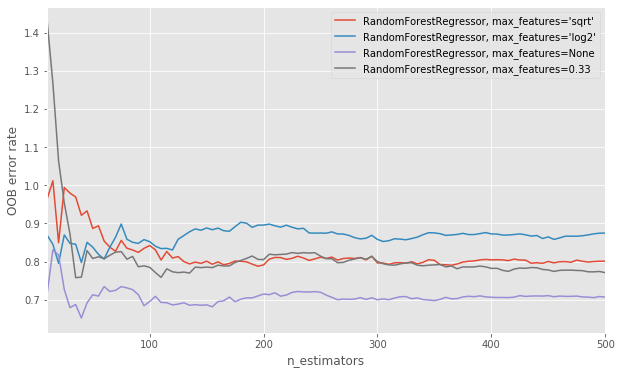

In [15]:
# Define response vars (target variable defined at the start)
exp_vars = [i for i in df2.columns if i != target_var]

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for 
# tracking the OOB error trajectory during training
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features='log2',
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=None",                  
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=None,           # Default. Uses all feats
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=0.33,           # Older recommendation. Used by R
                              oob_score=True,
                              random_state=rand_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error 
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

To pick the best parameters to use in the models below, pick the curve in the above plot which has the lowest error rate, and pick n_estimators where the curve has flattened out (or reached a minimum?)

### 4.3. Feature importances

In [22]:
# Set based on graph above
n_estimators = 40
max_features = None

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.35


,importance
chl-a_lake,0.406029
colour_lake,0.130992
tp_lake_prevsummer,0.099046
colour_lake_prevsummer,0.062593
chl-a_lake_prevsummer,0.033009
tp_catch,0.029221
q_lag1,0.027281
pptn_intense_lag1,0.020842
pptn_wintersum,0.017912
cyanobiovol_prevsummer,0.016003


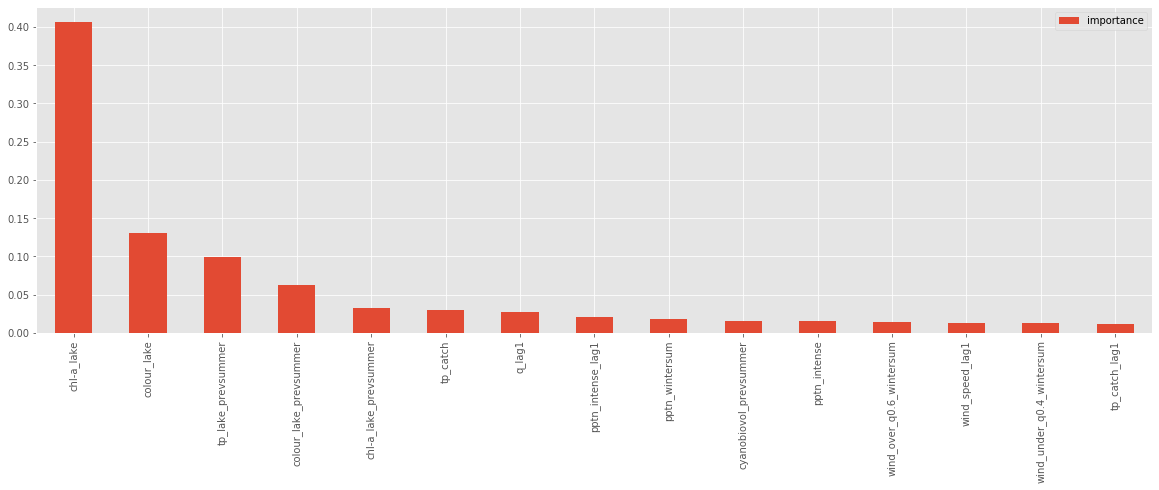

In [23]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

Based on this, the most important features to look further at are something like:

* chl-a_lake
* colour_lake

Not surprising, matches the correlation coefficient results


### 4.5. Recursive feature elimination

Recursive feature elimination attempts to find the best model using subsets of the available features. This is essentially the same as "stepwise" regression, except here we're using CV to avoid overfitting (as opposed to traditional "significance testing"). In the code below, I've used out-of-sample $R^2$ as a measure of performance. The best values obtained are pretty low, but remember that out-of-sample tests are much more stringent than their within-sample equivalents. The best overall indicator of perfornmance used in this notebook is the OOB score.

**Note:** Other scoring metrics are available. Use 

    sorted(sklearn.metrics.SCORERS.keys())
    
to print a list.

Optimal number of features: 1

Optimal features (in no particular order):
   chl-a_lake


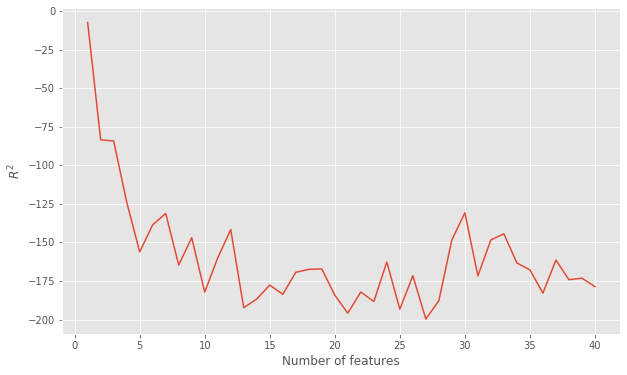

In [24]:
# Build same model as above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)

# Feature elimination with 3-fold CV
rfecv = RFECV(estimator=model, 
              step=1, 
              cv=3, 
              scoring='r2',
              n_jobs=-1)

selector = rfecv.fit(X_scaled, y)

print('Optimal number of features: %d' % rfecv.n_features_)
print('')
print ('Optimal features (in no particular order):')
for i in np.array(exp_vars)[selector.support_]:
    print('  ', i)
    
# Plot number of features vs. cross-validation score
plt.figure(figsize=(10,6))
plt.xlabel('Number of features')
plt.ylabel('$R^2$')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

Use the plot to decide roughly how many features to pick before things level off. Then think about which features are likeley to contain duplicate information. Lets try a consolidated list, removing duplicated features, and see how that model performs.

Interesting, suggests **only** using chl-a! I guess otherwise the limited amount of data means can't train things

In [48]:
# Reduce list of exp vars based on results above
exp_vars = [
    'chl-a_lake',
    'tp_lake_prevsummer',
#     'tp_lake'
#     'colour_lake',
#     'wind_speed'
#     'cyanobiovol_prevsummer'
           ]

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.47


,importance
chl-a_lake,0.8195
tp_lake_prevsummer,0.1805


**Comments**

Indeed, with chl-a alone, get OOB of 0.38. Adding in lake colour reduces it to 0.37. Then we need to decide whether we want that additional mechanism built in because we think it's an important process in reality, and whether there's enough data to parametrise it (probably not).

Adding in the cyanomax from the previous summer gives substantially worse result (OOB less than 0.3), whether lake colour is in there or not.

Similar story for mean monthly wind speed: OOB still at 0.37 when we add it in, i.e. no improvement on fit, but not a worse fit at least.

chl-a and tp_lake_prevsummer together (no others) gives a higher OOB of 0.47. Still 0.47 when add wind speed in. But anything else reduces it.

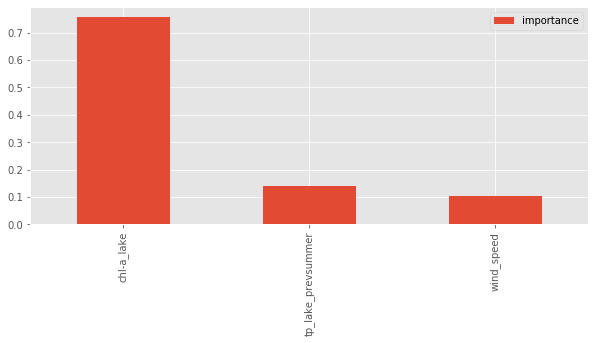

In [44]:
# Plot
res_df[:15].plot(kind='bar', figsize=(10,4))

## Summary

Chl-a is the only important variable. Adding tp_lake_prevsummer gives a higher OOB score though (together 0.47).

Other possibles that can be included without too much of a reduction in fit are:

- lake colour
- wind speed

